In [2]:
!pip install scikit-optimize
!pip install optuna

     |████████████████████████████████| 100 kB 4.3 MB/s 
     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 80 kB 8.1 MB/s 
     |████████████████████████████████| 209 kB 53.5 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 111 kB 50.2 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 144 kB 56.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=6bdc055a042dfb5a7a09eda43c116601edc9578d80cf925a02d1ba05e766aa37
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

import skopt
from skopt.space import Real, Categorical, Integer

import optuna
from optuna.visualization import plot_intermediate_values

import warnings
warnings.filterwarnings('ignore')

import time
%matplotlib inline

In [2]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [3]:
df_ = pd.read_csv('/content/train_df_step1.csv', index_col='Id')
df_t_= pd.read_csv('/content/test_df_step1.csv', index_col='Id')
df_

,MSSubClass,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,BsmtFullBath,BsmtHalfBath,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,YrSold,SaleType,SaleCondition,MoSold_sin,MoSold_cos,RenovatedY/N,AgeWhenSold,totBath,TotalBsmtFinSF,BsmtFinSF,2ndFloorY/N,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,SalePrice_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,3.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706,1.0,150,856,GasA,5.0,Y,SBrkr,854,1,0,...,0,Attchd,2003.0,2.0,2,548,3.0,3.0,2.0,0,61,2008,WD,Normal,8.660254e-01,5.000000e-01,no,5,3.5,706,706,1,4,274.000000,61,61,1,0,0,0,0,0,0,0,6.752270,5.364807,7.444249,9.041922,12.247694,8.360773
2,20,RL,Pave,3.0,Lvl,FR2,0.0,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978,1.0,284,1262,GasA,5.0,Y,SBrkr,0,0,1,...,1,Attchd,1976.0,2.0,2,460,3.0,3.0,2.0,298,0,2007,WD,Normal,5.000000e-01,-8.660254e-01,no,31,2.5,978,978,0,2,230.000000,298,0,0,0,0,0,0,0,0,0,7.140453,5.348694,7.140453,9.169518,12.109011,8.239065
3,60,RL,Pave,2.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486,1.0,434,920,GasA,5.0,Y,SBrkr,866,1,0,...,1,Attchd,2001.0,2.0,2,608,3.0,3.0,2.0,0,42,2008,WD,Normal,-1.000000e+00,-1.836970e-16,yes,7,3.5,486,486,1,2,304.000000,42,42,1,0,0,0,0,0,0,0,6.824374,5.695974,7.487734,9.328123,12.317167,8.410053
4,70,RL,Pave,2.0,Lvl,Corner,0.0,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216,1.0,540,756,GasA,4.0,Y,SBrkr,756,1,0,...,1,Detchd,1998.0,1.0,3,642,3.0,3.0,2.0,0,35,2006,WD,Abnorml,8.660254e-01,5.000000e-01,yes,91,2.0,216,216,1,3,214.000000,35,307,1,0,0,1,0,0,0,0,6.867974,5.502424,7.448334,9.164296,11.849398,8.340456
5,60,RL,Pave,2.0,Lvl,FR2,0.0,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655,1.0,490,1145,GasA,5.0,Y,SBrkr,1053,1,0,...,1,Attchd,2000.0,2.0,3,836,3.0,3.0,2.0,192,84,2008,WD,Normal,-2.449294e-16,1.000000e+00,no,8,3.5,655,655,1,4,278.666667,276,84,1,0,0,0,0,0,0,0,7.043160,5.498079,7.695303,9.565214,12.429216,8.619930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,20,FV,Pave,3.0,Lvl,Inside,0.0,Somerst,Norm,Norm,1Fam,1Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,410,1.0,811,1221,GasA,5.0,Y,SBrkr,0,1,0,...,0,Attchd,2004.0,2.0,2,400,3.0,3.0,2.0,0,113,2009,WD,Normal,-8.660254e-01,5.000000e-01,yes,5,3.0,410,410,0,3,200.000000,113,113,1,0,0,0,0,0,0,0,7.107425,5.315666,7.107425,8.922658,12.128111,8.206038
1456,60,RL,Pave,3.0,Lvl,Inside,0.0,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3.0,3.0,PConc,4.0,3.0,1.0,1.0,0,1.0,953,953,GasA,5.0,Y,SBrkr,694,0,0,...,1,Attchd,1999.0,2.0,2,460,3.0,3.0,2.0,0,40,2007,WD,Normal,-8.660254e-01,-5.000000e-01,yes,8,2.5,0,0,1,3,230.000000,40,40,1,0,

In [4]:
nominal = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional',
       'GarageType', 'SaleType', 'SaleCondition',
       'Street', 'CentralAir', 'RenovatedY/N', '2ndFloorY/N', 'PorchY/N',
       'BsmtFinSF2_cat', 'LowQualFinSF_cat', 'EnclosedPorch_cat',
       '3SsnPorch_cat', 'ScreenPorch_cat', 'MiscVal_cat', 'PoolArea_cat']

ordinal = ['MSSubClass', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'YrSold', 'AgeWhenSold', 'totBath', 'OtherRooms']

continuous = ['2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
       'GarageSpaceForCar', 'MasVnrArea', 'MoSold_cos', 'MoSold_sin',
       'OpenPorchSF', 'TotalBsmtFinSF', 'TotalBsmtSF', 'TotalPorchSF',
       'WoodDeckOpenPorch', 'WoodDeckSF', '1stFlrSF_log',
       'AverageRoomSF_log', 'GrLivArea_log', 'LotArea_log',
       'SalePrice_log', 'totSqFt_log']

In [5]:
# def standartize(df, columns):
#     st_df = df.copy()
    
#     scaler = StandardScaler()
    
#     st_df[columns] = scaler.fit_transform(df[columns])
#     print(df.shape, st_df.shape)
    
#     return st_df


# st_train_df = standartize(df_, ordinal + continuous)

# arr_to_standartize_test = ordinal + continuous
# arr_to_standartize_test.remove('SalePrice_log')
# st_test_df = standartize(df_t_, arr_to_standartize_test)

In [6]:
def one_hot_enc(train_df, test_df, columns):
    train_df['Status'] = 'Train'
    test_df['Status'] = 'Test'
    
    app_df = train_df.append(test_df)
    
    merded_app_df = pd.concat([pd.get_dummies(app_df[columns], drop_first=True), 
                           app_df.loc[:, app_df.columns[~app_df.columns.isin(columns)]]], axis=1)
    
    train_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Train']
    train_df_enc.drop('Status', axis=1, inplace=True)

    test_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Test']
    test_df_enc.drop(['Status', 'SalePrice_log'], axis=1, inplace=True)


    print(train_df_enc.shape, test_df_enc.shape)
    
    return train_df_enc, test_df_enc


train_df, test_df = one_hot_enc(df_, df_t_, nominal)

(1252, 207) (1459, 206)


In [7]:
# serial_corr_cols_to_drop = ['YrSold', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea_log', 'BsmtFinSF2_cat',
#         '1stFlrSF_log', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#         'BsmtFinSF1', 'BsmtFinSF2_cat', 'BsmtFinSF', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
#         'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch_cat',
#         '3SsnPorch_cat', 'PoolArea_cat', 'RoofStyle', 'RoofMatl', 'Condition2', 'BsmtFinType1', 'LandSlope', 'Exterior2nd']

# train_df1 = df_.copy()
# test_df1 = df_t_.copy()


# train_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)
# test_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)

# nominal1 = list(set(nominal) - set(serial_corr_cols_to_drop))
# ordinal1 = list(set(ordinal) - set(serial_corr_cols_to_drop))
# continuous1 = list(set(continuous) - set(serial_corr_cols_to_drop))


# st_train_df1 = standartize(train_df1, ordinal1 + continuous1)

# arr_to_standartize_test1 = ordinal1 + continuous1
# arr_to_standartize_test1.remove('SalePrice_log')
# st_test_df1 = standartize(test_df1, arr_to_standartize_test1)

In [8]:
X = train_df.drop('SalePrice_log', axis=1)
y = train_df['SalePrice_log']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

X1 = train_df.drop('SalePrice_log', axis=1)
y1 = train_df['SalePrice_log']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, shuffle=True, test_size=0.2)

kfolds = KFold(n_splits=6, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y, kfolds=kfolds):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds, n_jobs=2))
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds, n_jobs=2)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kfolds, n_jobs=2)
    return rmse, mae, r2

def display_cv_scores(rmse_, mae_, r2_):
    print(f'RMSE CV: {rmse_}  Mean RMSE: {round(rmse_.mean(),7)} Std RMSE: {round(rmse_.std(),7)}')
    print(f'MAE CV: {mae_}  Mean MAE: {round(mae_.mean(),7)} Std MAE: {round(mae_.std(),7)}')
    print(f'R2 CV: {r2_}  Mean R2: {round(r2_.mean(),7)} Std R2: {round(r2_.std(),7)}')

### GradientBoostingRegressor

#### Bayes

In [11]:
%%time

gbr_params = {
    'loss': ['huber'],
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),        
    'n_estimators': Integer(25, 1500, prior='uniform'),
    'subsample':  Real(0.6, 1., prior='uniform'),   
    'max_depth': Integer(1, 23, prior='uniform'),
    'min_samples_split': Real(0.00015, 0.4, prior='uniform'),
    'min_samples_leaf': Real(0.0007, 0.03, prior='uniform'),
    'max_features': Real(0.01, 1., prior='uniform')
}

search_gbr = skopt.BayesSearchCV(estimator=GradientBoostingRegressor(),
                                search_spaces=gbr_params,
                                scoring='neg_mean_squared_error',
                                n_iter=6,
                                cv=kfolds,
                                random_state=11,
                                n_jobs=3,
                                 verbose=10
                                )

search_gbr_ = search_gbr.fit(X, y)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:    9.1s remaining:   18.1s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:    9.2s remaining:    9.2s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:   15.9s remaining:    7.9s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   16.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:    9.2s remaining:   18.5s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:    9.7s remaining:    9.7s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:   18.5s remaining:    9.2s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   18.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:    9.4s remaining:   18.8s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:   10.2s remaining:   10.2s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:   18.6s remaining:    9.3s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   19.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:   18.1s remaining:   36.3s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:   36.4s remaining:   18.2s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   36.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   36.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:   15.0s remaining:   29.9s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:   15.0s remaining:   15.0s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:   28.6s remaining:   14.3s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   29.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:   10.5s remaining:   21.0s
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:   10.6s remaining:   10.6s
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:   20.2s remaining:   10.1s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   20.5s finished


CPU times: user 5.73 s, sys: 175 ms, total: 5.91 s
Wall time: 2min 25s


In [12]:
-search_gbr.best_score_, np.sqrt(-search_gbr.best_score_)

(0.011802931645371467, 0.10864129806556744)

In [13]:
dict(search_gbr.best_params_)

{'learning_rate': 0.0237561655340257,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.2961866687064254,
 'min_samples_leaf': 0.025738496329078393,
 'min_samples_split': 0.316902177562381,
 'n_estimators': 1031,
 'subsample': 0.7488889453990157}

#### optuna

In [9]:
def objective_gbr(trial, X, y, cv, scoring):
    params = {
        
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.3),        
        'n_estimators': trial.suggest_int("n_estimators", 25, 1500, step=25),
        'max_depth': trial.suggest_int('max_depth', 1, 35),
        'min_samples_split': trial.suggest_float("min_samples_split", 0.01, 1., step=0.1),
        'min_samples_leaf': trial.suggest_float("min_samples_leaf", 0.1, 5., step=0.1),
        'max_features': trial.suggest_float("max_features", 0.01, 1., step=0.01),
        
    }
    
    gr_reg = GradientBoostingRegressor(**params, loss='huber')
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

In [10]:
%%time

# sampler = optuna.samplers.RandomSampler(seed=7)
sampler = optuna.samplers.NSGAIISampler(seed=5)
# sampler = optuna.samplers.MOTPESampler(seed=5)
# sampler = optuna.samplers.TPESampler()


# Create study that minimizes
study_gbr = optuna.create_study(direction="minimize", sampler=sampler) #, sampler=sampler

# Pass additional arguments inside another function
func_gbr = lambda trial: objective_gbr(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study_gbr.optimize(func_gbr, timeout=60*110, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study_gbr.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.12067
CPU times: user 53.3 s, sys: 5.52 s, total: 58.8 s
Wall time: 1h 50min 2s


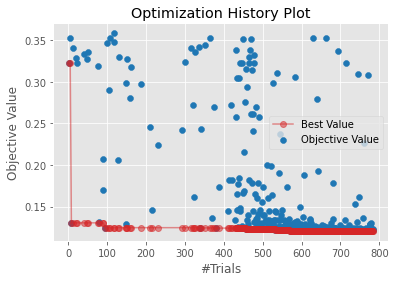

In [11]:
optuna.visualization.matplotlib.plot_optimization_history(study_gbr);

In [12]:
study_gbr.best_value, study_gbr.best_params

(0.12067236132334458,
 {'learning_rate': 0.06849154432579459,
  'max_depth': 4,
  'max_features': 0.26,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.11,
  'n_estimators': 375})

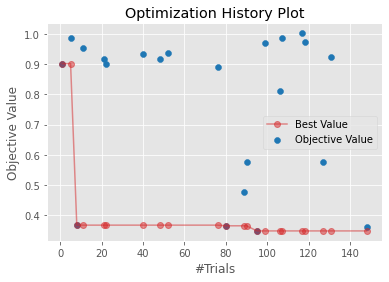

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_gbr);

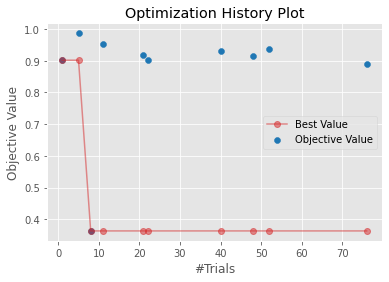

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_gbr);

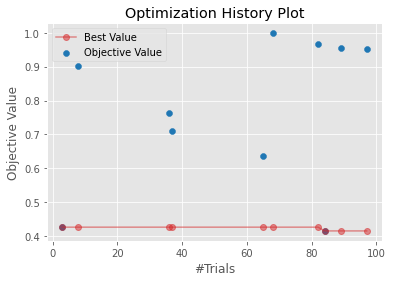

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_gbr);

In [ ]:
study_gbr.best_value, study_gbr.best_params

(0.3478644505424907,
 {'learning_rate': 0.1177367558645547,
  'max_depth': 28,
  'max_features': 0.7000000000000001,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.7100000000000001,
  'n_estimators': 1425})